In [1]:
pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [3]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [4]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

In [5]:
# Prepare dataset
categories = []
texts = []
base_dir = '/kaggle/input/cv-dataset/dataset/data/data'  # Update with the actual base directory

In [6]:
for category_folder in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category_folder)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith('.pdf'):
                pdf_path = os.path.join(category_path, filename)
                text = extract_text_from_pdf(pdf_path)
                texts.append(text)
                categories.append(category_folder)

In [7]:
# Create DataFrame
df = pd.DataFrame({'resume_text': texts, 'category': categories})
df.head()

,resume_text,category
0,"PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...",DESIGNER
1,PRINCIPLE DESIGNER / OWNER\nProfessional Summa...,DESIGNER
2,PROJECT DESIGNER\nSummary\nTeam-oriented and c...,DESIGNER
3,INTERIOR DESIGNER\nSummary\nA results oriented...,DESIGNER
4,PRESENTATION DESIGNER\nSummary\nCustomer Servi...,DESIGNER


In [8]:
df["category"].value_counts()

category
BUSINESS-DEVELOPMENT      120
INFORMATION-TECHNOLOGY    120
FINANCE                   118
CHEF                      118
ACCOUNTANT                118
ADVOCATE                  118
ENGINEERING               118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

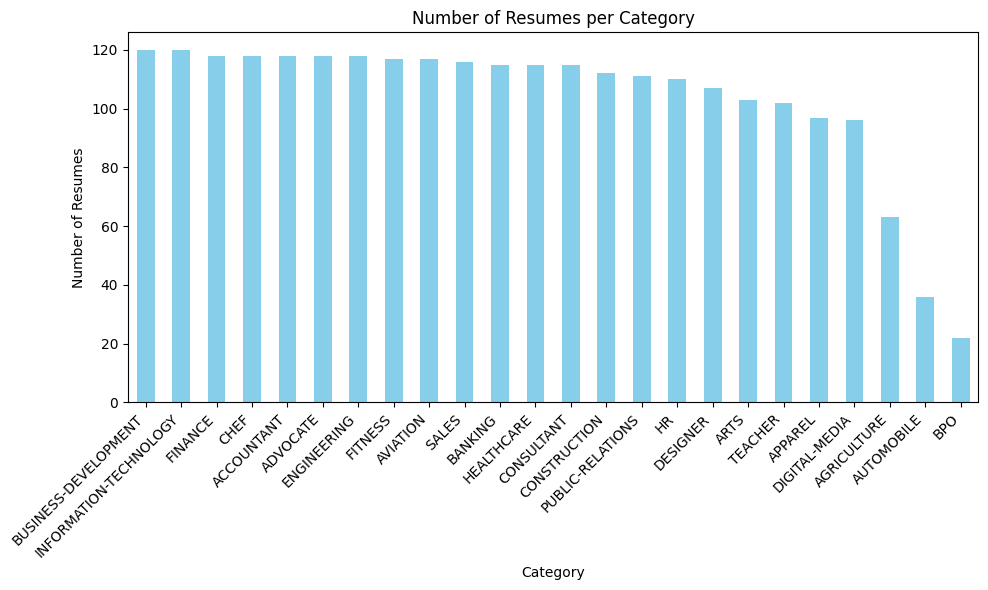

In [9]:
# Count the number of resumes in each category
category_counts = df['category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.title('Number of Resumes per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

In [10]:
cs = pd.read_csv("/kaggle/input/cv-dataset/dataset/Resume/Resume.csv")
cs.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [11]:
cs["Category"].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [12]:
# Encode labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['resume_text'], df['category_encoded'], test_size=0.3, random_state=42)

In [13]:
from imblearn.over_sampling import SMOTE

# Example using SMOTE for oversampling
smote = SMOTE(random_state=42)

In [14]:
# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

# **Logistic Regression**

In [18]:
# Parameter grid for Logistic Regression
solvers = ['lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
lr_parameters = dict(solver=solvers,penalty=penalty,C=c_values)# define grid search
lg = LogisticRegression(max_iter=5000, multi_class='ovr')

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=lg, param_grid=lr_parameters, cv=5)

grid_search.fit(X_train_tfidf, y_train)

# Best parameters 
grid_search.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [15]:
# Model Selection
model = LogisticRegression( max_iter=5000, C = 100, penalty = 'l2', solver = 'liblinear',multi_class='ovr')

# Train the model
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.7064343163538874
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.68      0.85      0.76        40
              ADVOCATE       0.66      0.66      0.66        38
           AGRICULTURE       0.70      0.39      0.50        18
               APPAREL       0.64      0.50      0.56        32
                  ARTS       0.52      0.57      0.54        30
            AUTOMOBILE       0.67      0.31      0.42        13
              AVIATION       0.80      0.80      0.80        35
               BANKING       0.62      0.74      0.68        34
                   BPO       0.67      0.25      0.36         8
  BUSINESS-DEVELOPMENT       0.66      0.66      0.66        29
                  CHEF       0.95      0.67      0.78        30
          CONSTRUCTION       0.91      0.77      0.83        39
            CONSULTANT       0.56      0.42      0.48        33
              DESIGNER       0.87      0.83      0

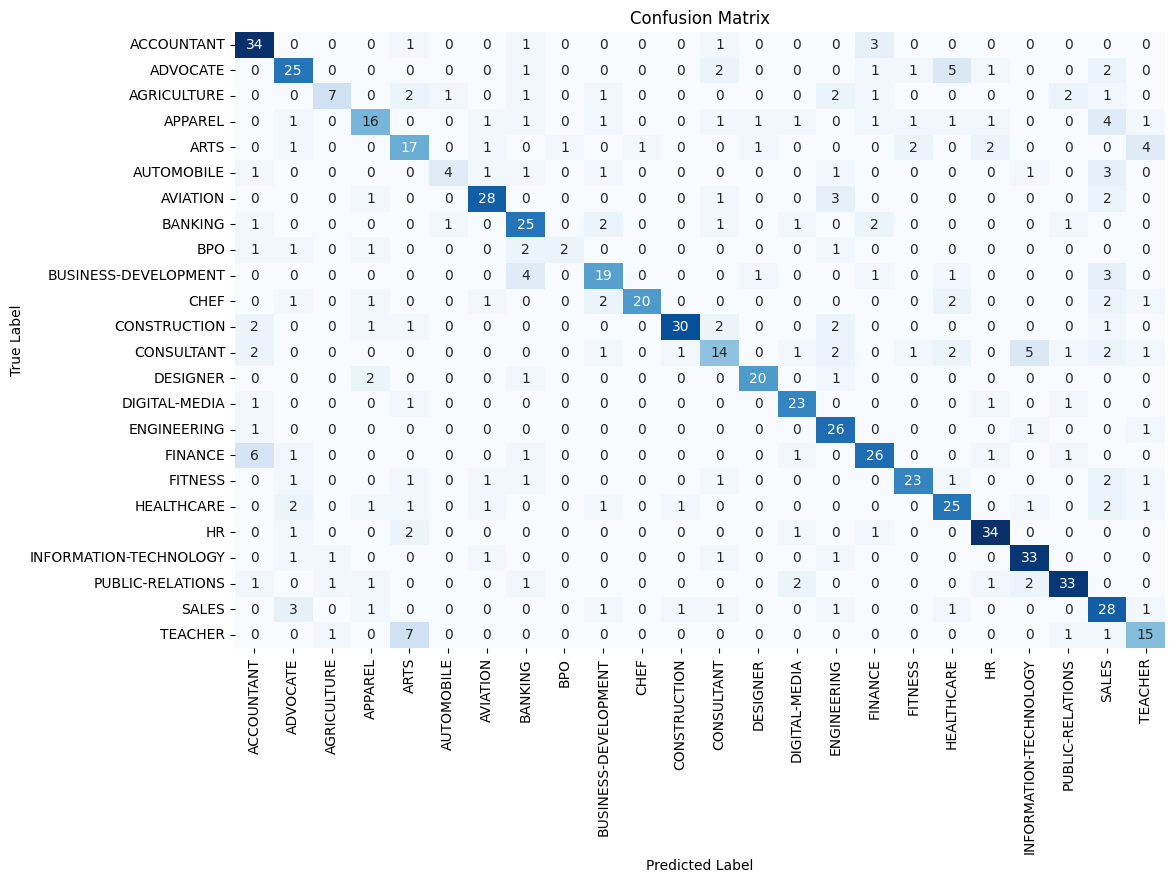

In [16]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Decision Tree**

In [16]:
# Decision Tree classifier
classifier = DecisionTreeClassifier()
# Parameter grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# The best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [17]:
# Initialize RandomForestClassifier with best parameters
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2)
dt_classifier.fit(X_train_tfidf, y_train)
# Model Evaluation
y_pred = dt_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.5294906166219839
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.72      0.82      0.77        40
              ADVOCATE       0.53      0.63      0.58        38
           AGRICULTURE       0.38      0.28      0.32        18
               APPAREL       0.44      0.44      0.44        32
                  ARTS       0.29      0.23      0.26        30
            AUTOMOBILE       0.10      0.08      0.09        13
              AVIATION       0.67      0.69      0.68        35
               BANKING       0.21      0.24      0.22        34
                   BPO       0.25      0.12      0.17         8
  BUSINESS-DEVELOPMENT       0.38      0.45      0.41        29
                  CHEF       0.95      0.70      0.81        30
          CONSTRUCTION       0.82      0.85      0.84        39
            CONSULTANT       0.39      0.33      0.36        33
              DESIGNER       0.88      0.62      0

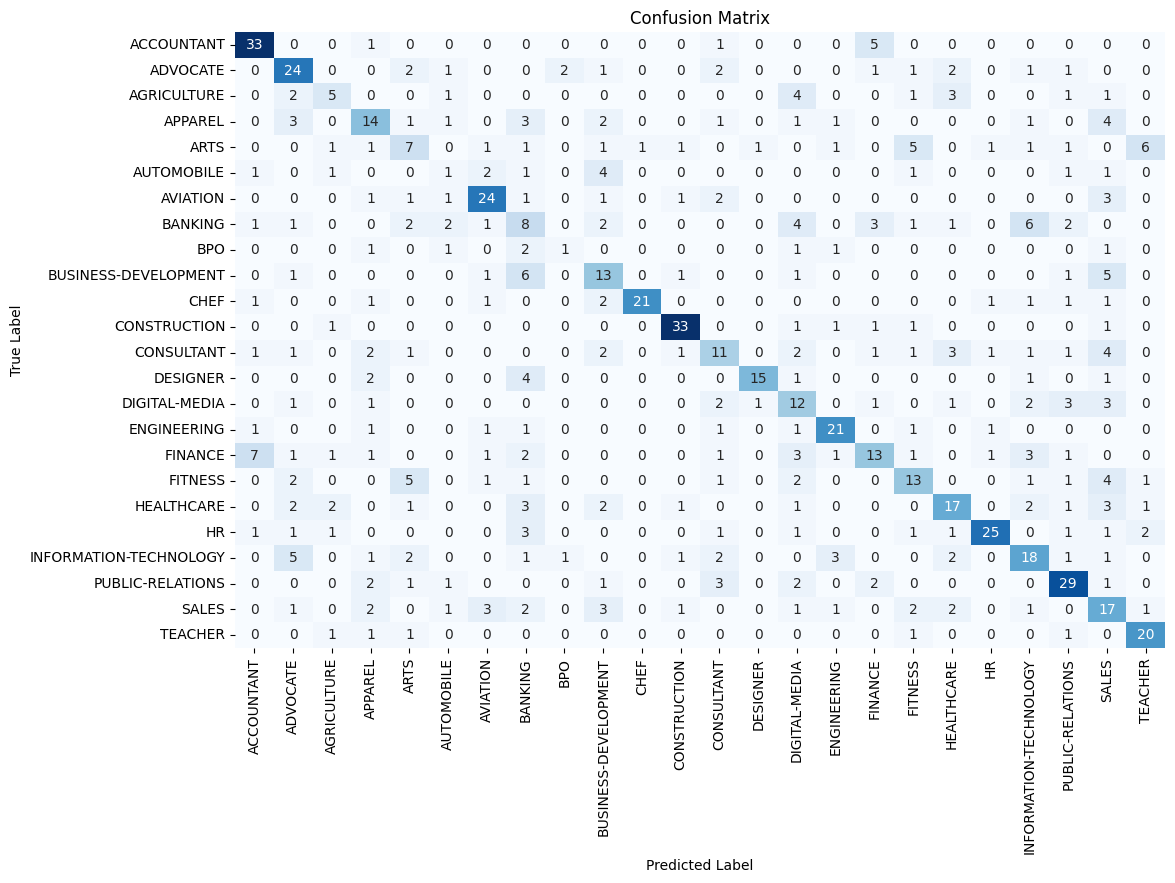

In [18]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Random Forest**

In [20]:
# Number of trees
n_estimators = [50, 80, 100]
max_depth = [4, 6, 8]
min_samples_split = [50, 100, 150]
min_samples_leaf = [40, 50]

# Hyperparameter Grid
rf_parameters = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf}

# Initialize RandomForestClassifier with GridSearchCV
rf_classifier = RandomForestClassifier()

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=rf_parameters, cv=5)

grid_search.fit(X_train_tfidf, y_train)

# Best parameters 
grid_search.best_params_

{'max_depth': 8,
 'min_samples_leaf': 40,
 'min_samples_split': 100,
 'n_estimators': 100}

In [19]:
# Best parameters from grid search
best_params = {'max_depth': 8,
               'min_samples_leaf': 40,
               'min_samples_split': 100,
               'n_estimators': 100}

# Initialize RandomForestClassifier with best parameters
rf_classifier = RandomForestClassifier(**best_params)

# Train model using the best parameters
rf_classifier.fit(X_train_tfidf, y_train)
# Evaluate the model
y_pred = rf_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6005361930294906
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.49      0.97      0.65        40
              ADVOCATE       0.80      0.74      0.77        38
           AGRICULTURE       0.75      0.17      0.27        18
               APPAREL       0.82      0.44      0.57        32
                  ARTS       0.00      0.00      0.00        30
            AUTOMOBILE       0.50      0.23      0.32        13
              AVIATION       0.71      0.86      0.78        35
               BANKING       0.83      0.15      0.25        34
                   BPO       0.33      0.12      0.18         8
  BUSINESS-DEVELOPMENT       0.53      0.55      0.54        29
                  CHEF       0.53      0.80      0.64        30
          CONSTRUCTION       0.83      0.77      0.80        39
            CONSULTANT       0.86      0.18      0.30        33
              DESIGNER       0.62      0.83      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


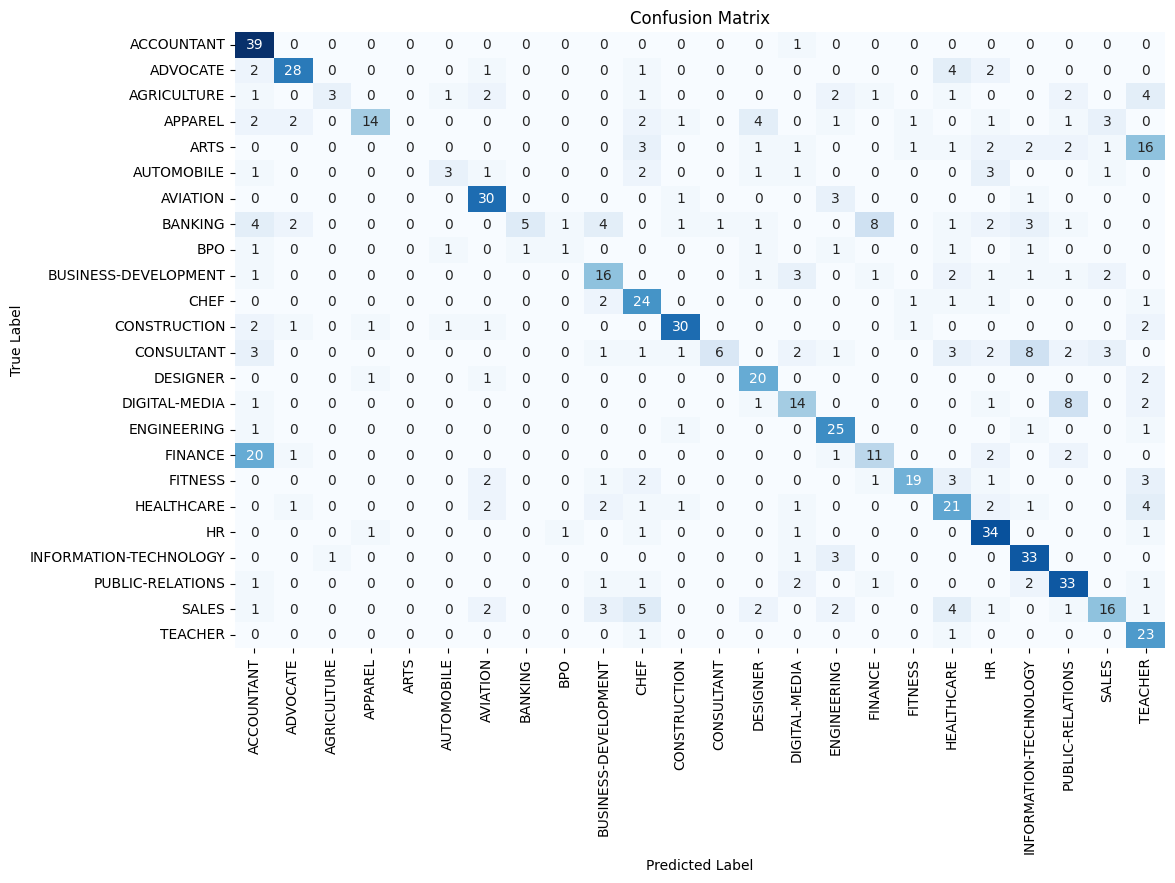

In [20]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **XGBoost**

In [31]:
# Parameter grid for xgboost
xgb_parameters = {'max_depth': [1,3,5], 'n_estimators': [2,5,10], 'learning_rate': [.01 , .1, .5]}

xgb_classifier = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_parameters, cv=5)

# Grid search
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10}

In [21]:
xgb_model = XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 10)
xgb_model.fit(X_train_tfidf, y_train)
# Evaluate the model
y_pred = xgb_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.7024128686327078
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.73      0.88      0.80        40
              ADVOCATE       0.82      0.71      0.76        38
           AGRICULTURE       0.62      0.44      0.52        18
               APPAREL       0.67      0.50      0.57        32
                  ARTS       0.56      0.50      0.53        30
            AUTOMOBILE       0.43      0.46      0.44        13
              AVIATION       0.82      0.77      0.79        35
               BANKING       0.54      0.65      0.59        34
                   BPO       1.00      0.25      0.40         8
  BUSINESS-DEVELOPMENT       0.52      0.59      0.55        29
                  CHEF       0.92      0.80      0.86        30
          CONSTRUCTION       0.84      0.95      0.89        39
            CONSULTANT       0.59      0.52      0.55        33
              DESIGNER       0.86      0.75      0

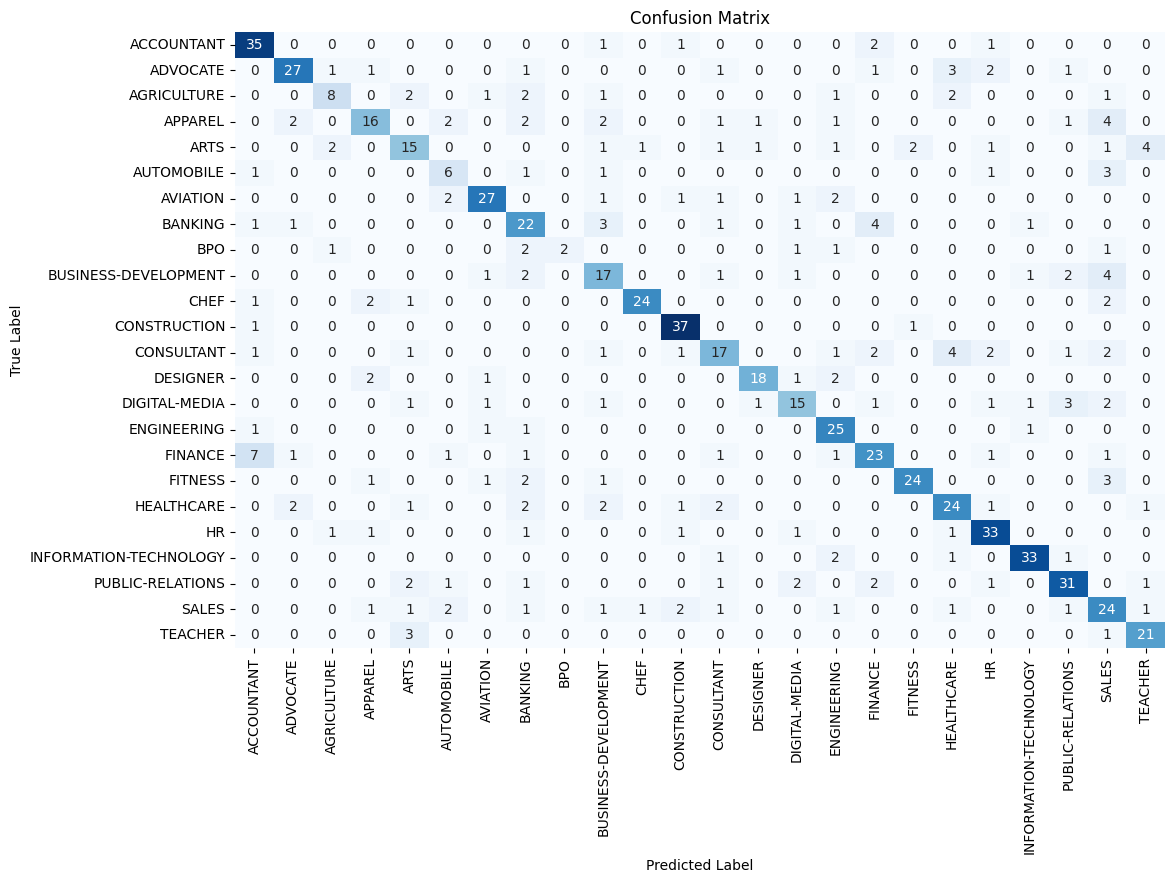

In [22]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **SVM**

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_classifier = SVC(decision_function_shape='ovr')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
grid_search.best_params_

In [23]:
sv = SVC(C=10, kernel='linear',gamma= 'scale',decision_function_shape='ovr',probability=True)
# Train the model
sv.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = sv.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6554959785522788
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.71      0.85      0.77        40
              ADVOCATE       0.56      0.71      0.63        38
           AGRICULTURE       0.67      0.33      0.44        18
               APPAREL       0.62      0.50      0.55        32
                  ARTS       0.36      0.53      0.43        30
            AUTOMOBILE       0.67      0.15      0.25        13
              AVIATION       0.71      0.63      0.67        35
               BANKING       0.61      0.65      0.63        34
                   BPO       0.50      0.12      0.20         8
  BUSINESS-DEVELOPMENT       0.44      0.55      0.49        29
                  CHEF       0.95      0.63      0.76        30
          CONSTRUCTION       0.91      0.77      0.83        39
            CONSULTANT       0.45      0.39      0.42        33
              DESIGNER       0.82      0.75      0

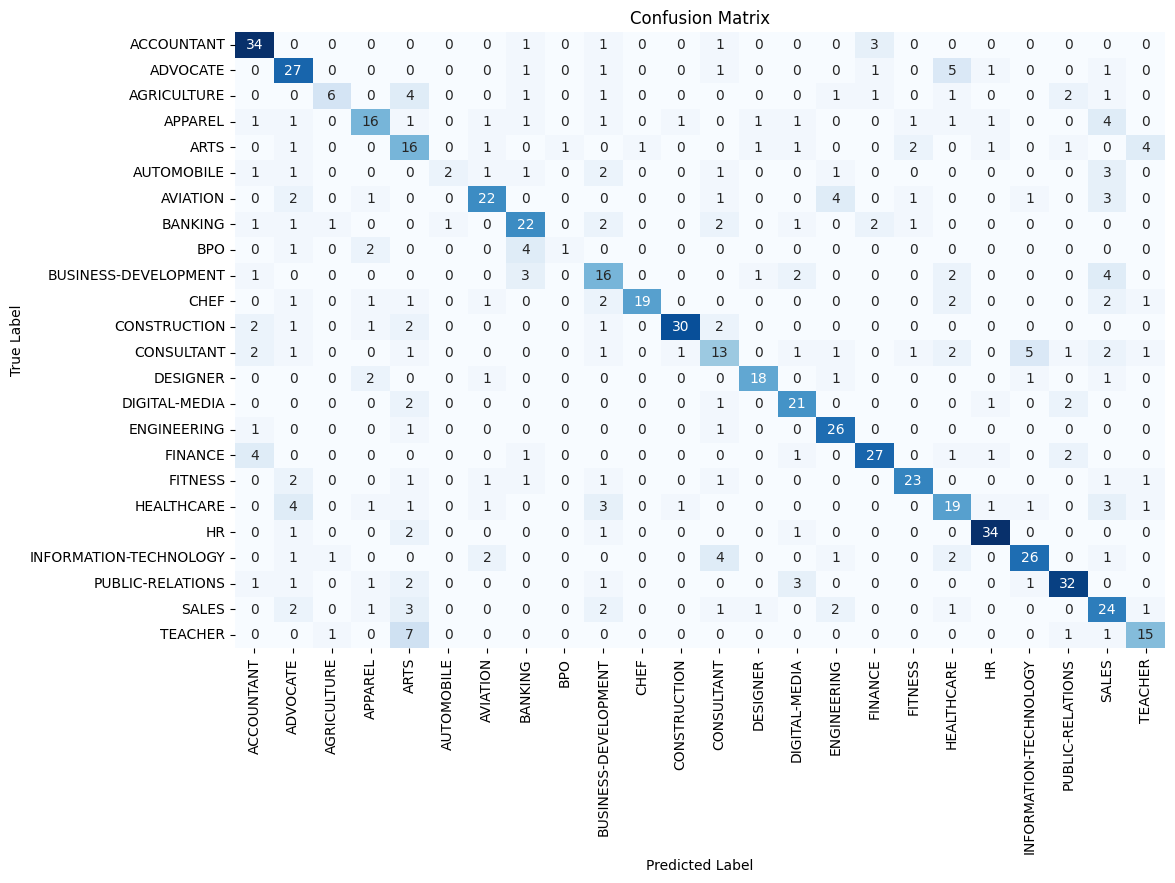

In [24]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **K-Neighbors (KNN) Classifier**

In [37]:
from sklearn.neighbors import KNeighborsClassifier

# KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'p': [1, 2]  
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
grid_search.best_params_

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

In [25]:
from sklearn.neighbors import KNeighborsClassifier
best_knn =  KNeighborsClassifier(algorithm='auto', n_neighbors=2, p=1, weights= 'distance')
# Model training
best_knn.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = sv.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6554959785522788
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.71      0.85      0.77        40
              ADVOCATE       0.56      0.71      0.63        38
           AGRICULTURE       0.67      0.33      0.44        18
               APPAREL       0.62      0.50      0.55        32
                  ARTS       0.36      0.53      0.43        30
            AUTOMOBILE       0.67      0.15      0.25        13
              AVIATION       0.71      0.63      0.67        35
               BANKING       0.61      0.65      0.63        34
                   BPO       0.50      0.12      0.20         8
  BUSINESS-DEVELOPMENT       0.44      0.55      0.49        29
                  CHEF       0.95      0.63      0.76        30
          CONSTRUCTION       0.91      0.77      0.83        39
            CONSULTANT       0.45      0.39      0.42        33
              DESIGNER       0.82      0.75      0

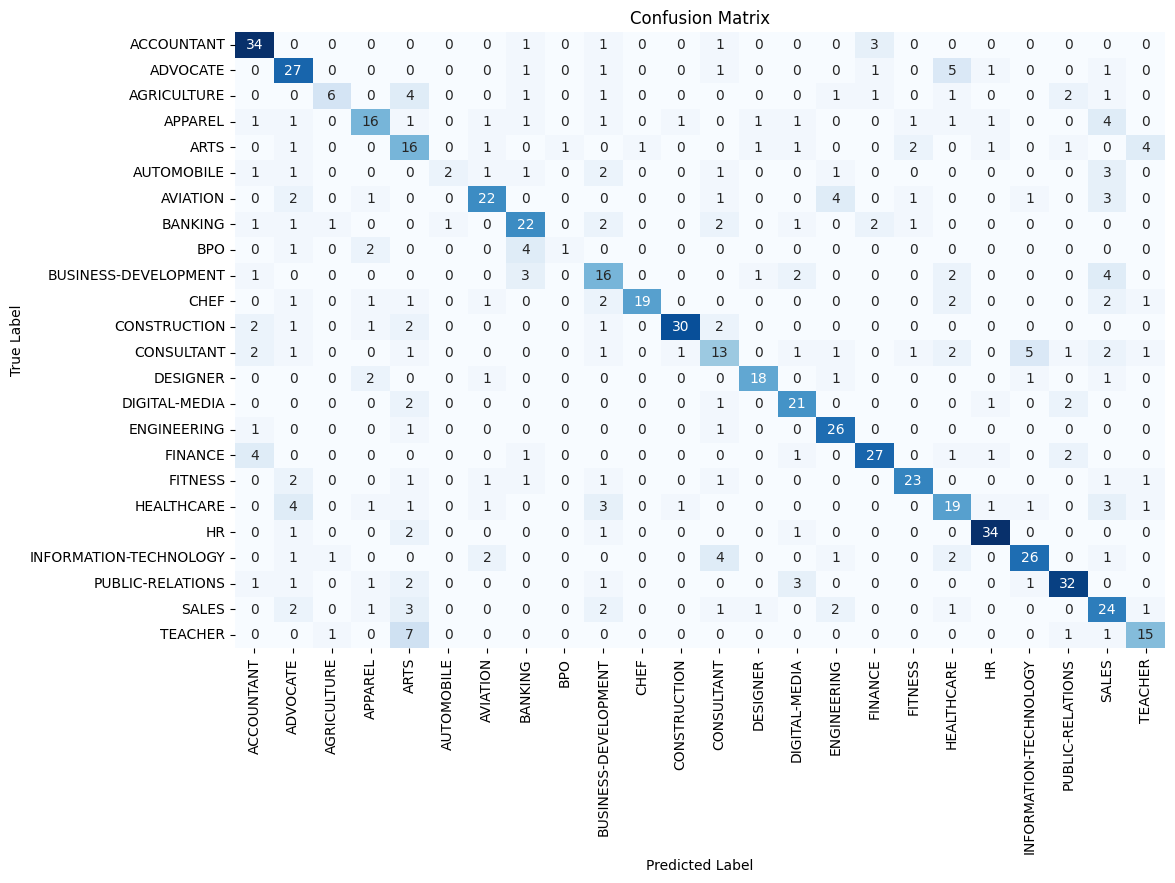

In [26]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
import joblib

# Save the model and other objects
joblib.dump(xgb_model, 'resume_categorizer_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# **Deep Learning**

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

In [41]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
history = lstm_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_test_tfidf, y_test))

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 299s 9s/step - accuracy: 0.0374 - loss: 3.1780 - val_accuracy: 0.0536 - val_loss: 3.1756
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.0417 - loss: 3.1783 - val_accuracy: 0.0509 - val_loss: 3.1769
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - accuracy: 0.0429 - loss: 3.1785 - val_accuracy: 0.0429 - val_loss: 3.1779
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - accuracy: 0.0307 - loss: 3.1793 - val_accuracy: 0.0483 - val_loss: 3.1767
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.0434 - loss: 3.1793 - val_accuracy: 0.0456 - val_loss: 3.1772


In [53]:
# Evaluate the model
y_pred_prob = lstm_model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
Accuracy: 0.045576407506702415
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.00      0.00      0.00        40
              ADVOCATE       0.00      0.00      0.00        38
           AGRICULTURE       0.00      0.00      0.00        18
               APPAREL       0.00      0.00      0.00        32
                  ARTS       0.00      0.00      0.00        30
            AUTOMOBILE       0.00      0.00      0.00        13
              AVIATION       0.00      0.00      0.00        35
               BANKING       0.05      1.00      0.09        34
                   BPO       0.00      0.00      0.00         8
  BUSINESS-DEVELOPMENT       0.00      0.00      0.00        29
                  CHEF       0.00      0.00      0.00        30
          CONSTRUCTION       0.00      0.00      0.00        39
            CONSULTANT       0.00      0.00      0.00        33
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


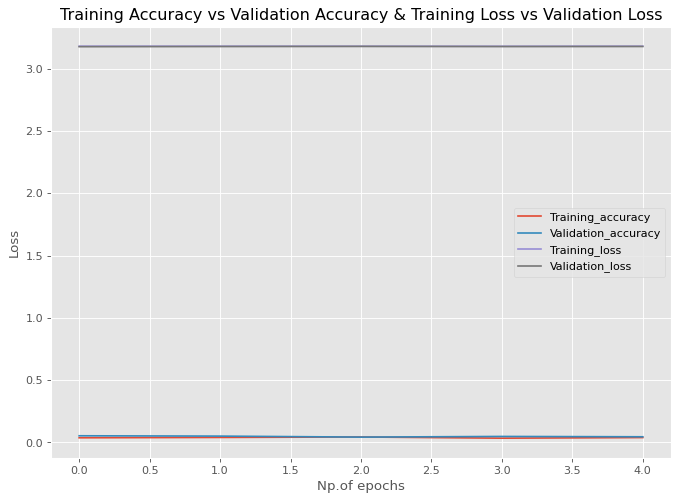

In [54]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figure(figsize=(10, 7), dpi=80)
# plt.plot([1, 0], [0, 1], 'k--')
plt.plot(history.history['accuracy'],label='Training_accuracy')
plt.plot(history.history['val_accuracy'],label='Validation_accuracy')
plt.plot(history.history['loss'],label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy & Training Loss vs Validation Loss')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.xlabel('Np.of epochs')
plt.ylabel('Loss')
plt.show()

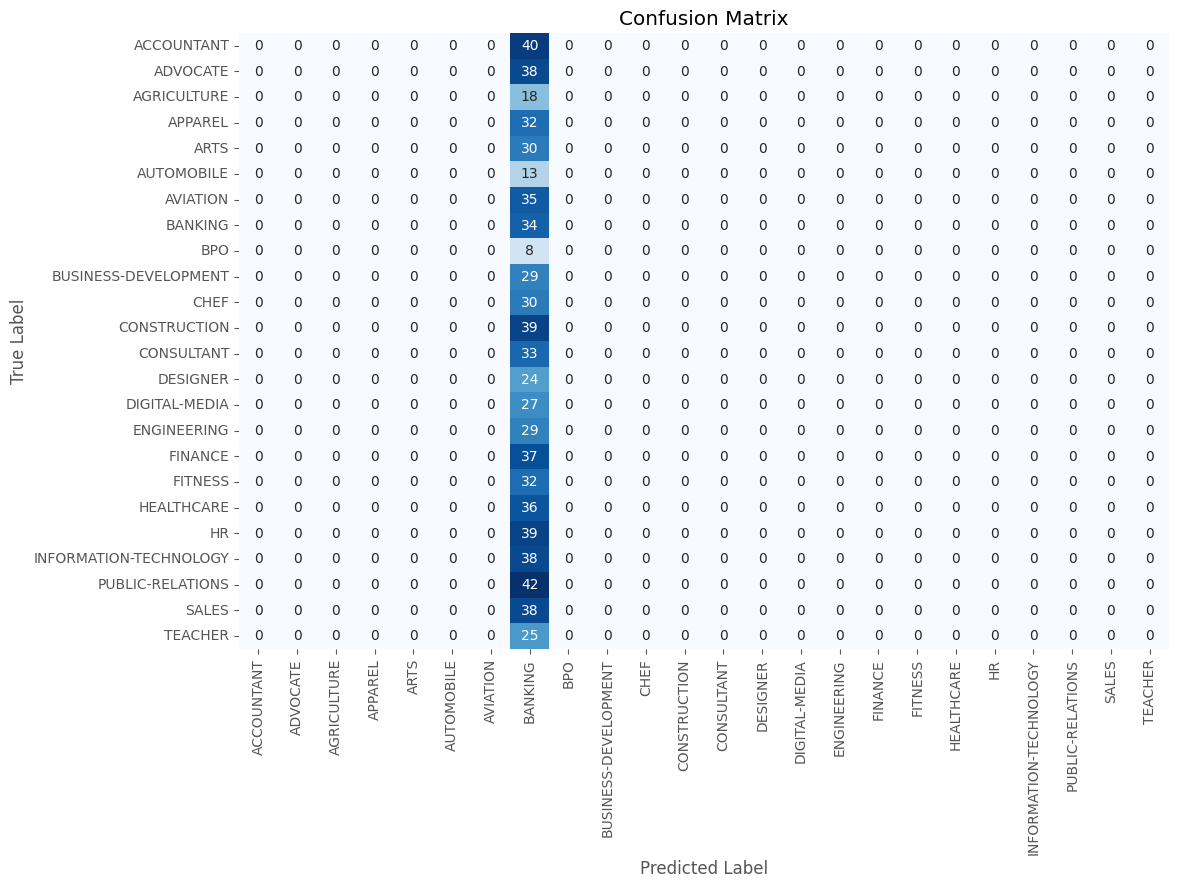

In [55]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()